### need to check issues on no data defaulting into bare areas - problems identified in tassie
examples are hobart 2010 and 2015 or recent september tests on AWS

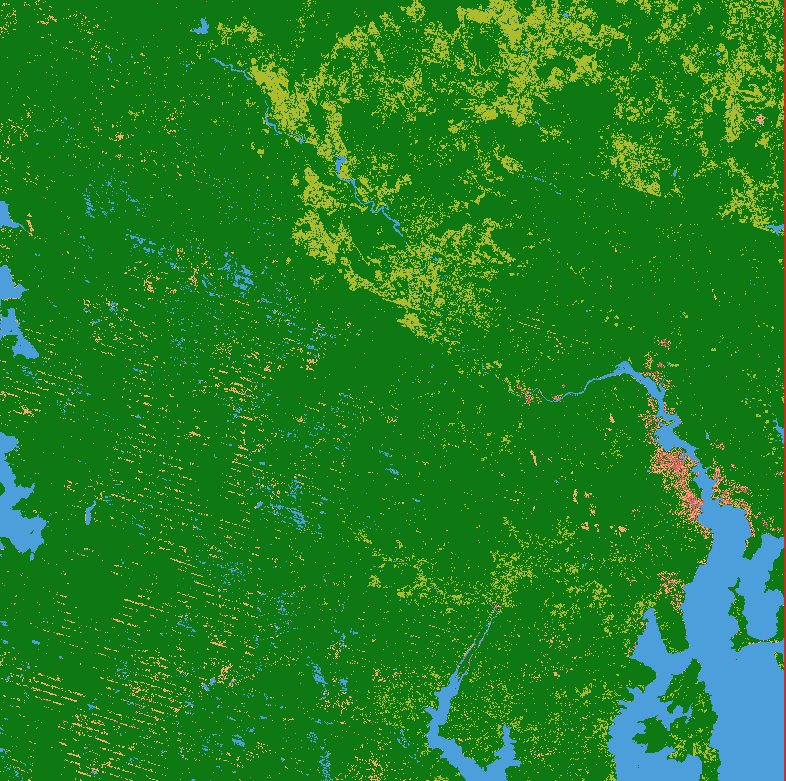

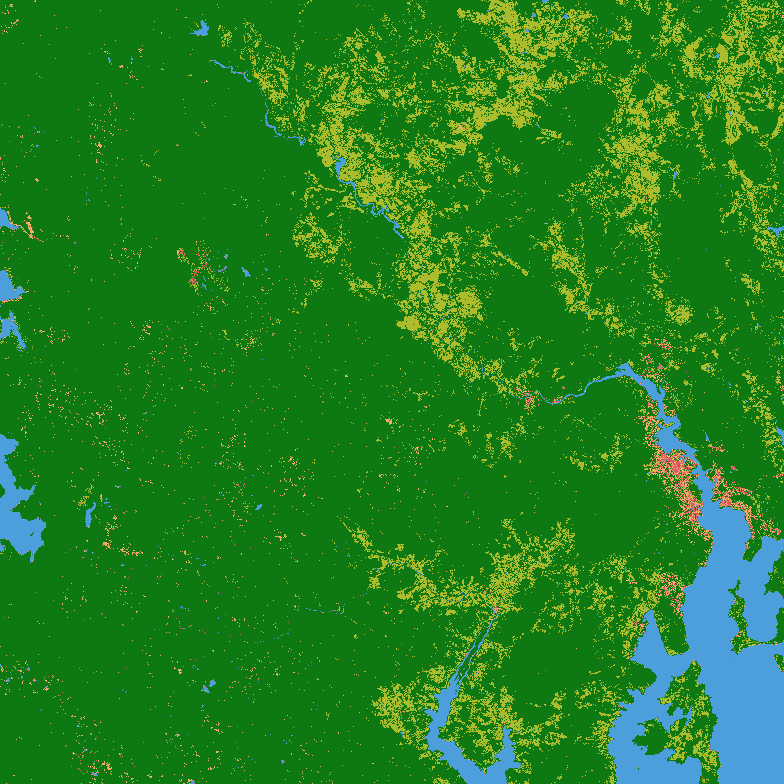

In [1]:
import os, sys, copy
import yaml
import numpy as np
import xarray as xr
import pickle

from itertools import groupby
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import datacube
from datacube.storage import masking
from datacube.virtual import catalog_from_file
from datacube.utils.geometry import CRS
from datacube.helpers import write_geotiff

import importlib
from datacube.virtual import DEFAULT_RESOLVER
from datacube.testutils.io import rio_slurp_xarray

dc = datacube.Datacube()

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


In [2]:
# AWS or Gadi
service = '/home/jovyan/development/'

sys.path.append(str(service)+"dea-notebooks/Scripts")
from dea_classificationtools import sklearn_unflatten
from dea_classificationtools import sklearn_flatten

sys.path.append(str(service)+"livingearth_lccs")
from le_lccs.le_ingest import gridded_ingest

sys.path.append(str(service)+"livingearth_australia")
import le_plugins

sys.path.append(os.path.abspath(str(service)+"livingearth_australia/le_plugins"))

In [3]:
# loading extents from yaml Dan prepared, just change site_name to tile interested in from our 16 test sites
# yaml_sites_file = os.path.abspath(str(service)+"livingearth_australia/vec_rois/au_test_sites.yaml")
yaml_sites_file = os.path.abspath(str(service)+"chris_leaust_testing/notebooks/misc/au_test_sites.yaml")

with open(yaml_sites_file, "r") as f:
    site_config = yaml.safe_load(f)

site_name = "Ayr"
extent_x = [site_config[site_name]["min_x"],
            site_config[site_name]["max_x"]]
extent_y = [site_config[site_name]["min_y"],
            site_config[site_name]["max_y"]]

crs = "EPSG:3577"
res = (-100, 100)
time = ("2015-01-01", "2015-12-31")
query =({'time': time,
             'x':extent_x,
            'y':extent_y,
            'crs':crs,
            'resolution':res})

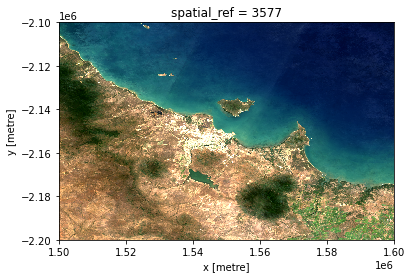

In [4]:
# Load Landsat
geomedian = dc.load(product="ls8_nbart_geomedian_annual", **query)
geomedian = masking.mask_invalid_data(geomedian).squeeze().drop('time')
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)

In [5]:
DEM_dcload = dc.load(product="ga_srtm_dem1sv1_0", **query)
DEM_dcload

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*

In [6]:
# datacube functions to load in a virtual product from recipe
catalog = catalog_from_file(service+'livingearth_australia/le_plugins/virtual_product_cat.yaml')

In [7]:
aggregations = ["FC_summary"]
for aggregate in aggregations:
    loc = "le_plugins"
    trans_loc = importlib.import_module(f"{loc}.{aggregate}")
    DEFAULT_RESOLVER.register('aggregate', aggregate, getattr(trans_loc, aggregate))

product = catalog['fc_veg']
fc_veg = product.load(dc, **query)
fc_veg

<xarray.Dataset>
Dimensions:      (time: 1, x: 1000, y: 1000)
Coordinates:
    spatial_ref  int32 3577
  * x            (x) float64 1.5e+06 1.5e+06 1.5e+06 ... 1.6e+06 1.6e+06 1.6e+06
  * y            (y) float64 -2.1e+06 -2.1e+06 -2.1e+06 ... -2.2e+06 -2.2e+06
  * time         (time) datetime64[ns] 2015-01-01
Data variables:
    fc_veg       (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0

In [8]:
# wofs_mask
product = catalog['wofs_mask']
wofs_mask = product.load(dc, **query)
wofs_mask

<xarray.Dataset>
Dimensions:      (time: 1, x: 1000, y: 1000)
Coordinates:
    spatial_ref  int32 3577
  * x            (x) float64 1.5e+06 1.5e+06 1.5e+06 ... 1.6e+06 1.6e+06 1.6e+06
  * y            (y) float64 -2.1e+06 -2.1e+06 -2.1e+06 ... -2.2e+06 -2.2e+06
  * time         (time) datetime64[ns] 2015-01-01
Data variables:
    wofs_mask    (time, y, x) bool True True True True ... False False False
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [9]:
product = catalog['wofs_annual_summary']
wofs_annual_summary = product.load(dc, **query)
wofs_annual_summary

<xarray.Dataset>
Dimensions:      (time: 1, x: 1000, y: 1000)
Coordinates:
    spatial_ref  int32 3577
  * x            (x) float64 1.5e+06 1.5e+06 1.5e+06 ... 1.6e+06 1.6e+06 1.6e+06
  * y            (y) float64 -2.1e+06 -2.1e+06 -2.1e+06 ... -2.2e+06 -2.2e+06
  * time         (time) datetime64[ns] 2015-01-01
Data variables:
    frequency    (time, y, x) float32 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [10]:
# best geomedian for saltpan_mask and mudflat mask
product = catalog['best_pixel_gm']
best_pixel_gm = product.load(dc, **query)
best_pixel_gm

<xarray.Dataset>
Dimensions:      (time: 1, x: 1000, y: 1000)
Coordinates:
    spatial_ref  int32 3577
  * x            (x) float64 1.5e+06 1.5e+06 1.5e+06 ... 1.6e+06 1.6e+06 1.6e+06
  * y            (y) float64 -2.1e+06 -2.1e+06 -2.1e+06 ... -2.2e+06 -2.2e+06
  * time         (time) datetime64[ns] 2015-01-01
Data variables:
    blue         (time, y, x) float32 527.0 524.0 518.0 ... 523.0 565.0 669.0
    green        (time, y, x) float32 497.0 488.0 478.0 ... 919.0 943.0 963.0
    red          (time, y, x) float32 214.0 209.0 202.0 ... 724.0 708.0 931.0
    nir          (time, y, x) float32 141.0 137.0 131.0 ... 4284.0 4461.0 3353.0
    swir1        (time, y, x) float32 95.0 93.0 88.0 ... 2056.0 2039.0 2493.0
    swir2        (time, y, x) float32 75.0 74.0 69.0 ... 1092.0 1063.0 1701.0
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [11]:
# mangroves
product = catalog['mangroves']
mangroves = product.load(dc, **query)
mangroves

<xarray.Dataset>
Dimensions:      (time: 1, x: 1000, y: 1000)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-01
  * y            (y) float64 -2.1e+06 -2.1e+06 -2.1e+06 ... -2.2e+06 -2.2e+06
  * x            (x) float64 1.5e+06 1.5e+06 1.5e+06 ... 1.6e+06 1.6e+06 1.6e+06
    spatial_ref  int32 3577
Data variables:
    extent       (time, y, x) int16 -1 -1 -1 -1 -1 -1 -1 ... -1 -1 -1 -1 -1 -1
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [12]:
# collate all data for manual application of plugin
variables_xarray_list = []
variables_xarray_list.append(fc_veg)
variables_xarray_list.append(wofs_mask)
variables_xarray_list.append(best_pixel_gm)

# Merge to a single dataframe
data_collate = xr.merge(variables_xarray_list)

In [13]:
year = str(data_collate.time.data[0])
data = data_collate.squeeze(dim='time', drop=True)

# load DEM
# DEM = rio_slurp_xarray("s3://dea-public-data/projects/LCCS/lte6_0_1bit.tif", gbox=data.geobox)
DEM = dc.load(product="ga_srtm_dem1sv1_0", like=data, measurements=["dem_h"]).squeeze(dim='time', drop=True)
DEM_mask = np.where((DEM['dem_h'].values <= 6), 1, 0)


# Load mangroves
mangroves = dc.load(product="mangrove_cover", like=data, measurements=["extent"], time=year)

# calculate SI5, mudflat & saltpan masks, retaining nans from geomedian
si5 = (data['blue'] * data['red']) / (data['green'])
mudflat_mask = np.where(si5 > 1000, 1, 0)
mudflat_mask_nan = np.where((data['red'] == 0), np.nan, mudflat_mask)
saltpan_mask = np.where(si5 < 1500, 1, 0)
saltpan_mask_nan = np.where((data['red'] == 0), np.nan, saltpan_mask)

veg = ((data.fc_veg.data) * (1 - (data.wofs_mask.data)) * saltpan_mask_nan * (1-(mudflat_mask_nan * DEM_mask)))#.compute()

if mangroves:
    veg = np.where(mangroves.values == 1, 1, veg)

vegetat_veg_cat = xr.DataArray(veg, coords=data.coords, dims=data.fc_veg.dims)


In [14]:
fc_veg_da = xr.DataArray(data.fc_veg.data, coords=data.coords, dims=data.fc_veg.dims)
wofs_mask_da = xr.DataArray(data.wofs_mask.data, coords=data.coords, dims=data.fc_veg.dims)
saltpan_mask_nan_da = xr.DataArray(saltpan_mask_nan, coords=data.coords, dims=data.fc_veg.dims)
mudflat_mask_nan_da = xr.DataArray(mudflat_mask_nan, coords=data.coords, dims=data.fc_veg.dims)
DEM_mask_da = xr.DataArray(DEM_mask, coords=data.coords, dims=data.fc_veg.dims)
mangrove_da = (mangroves['extent'] == 1).squeeze(dim='time', drop=True)


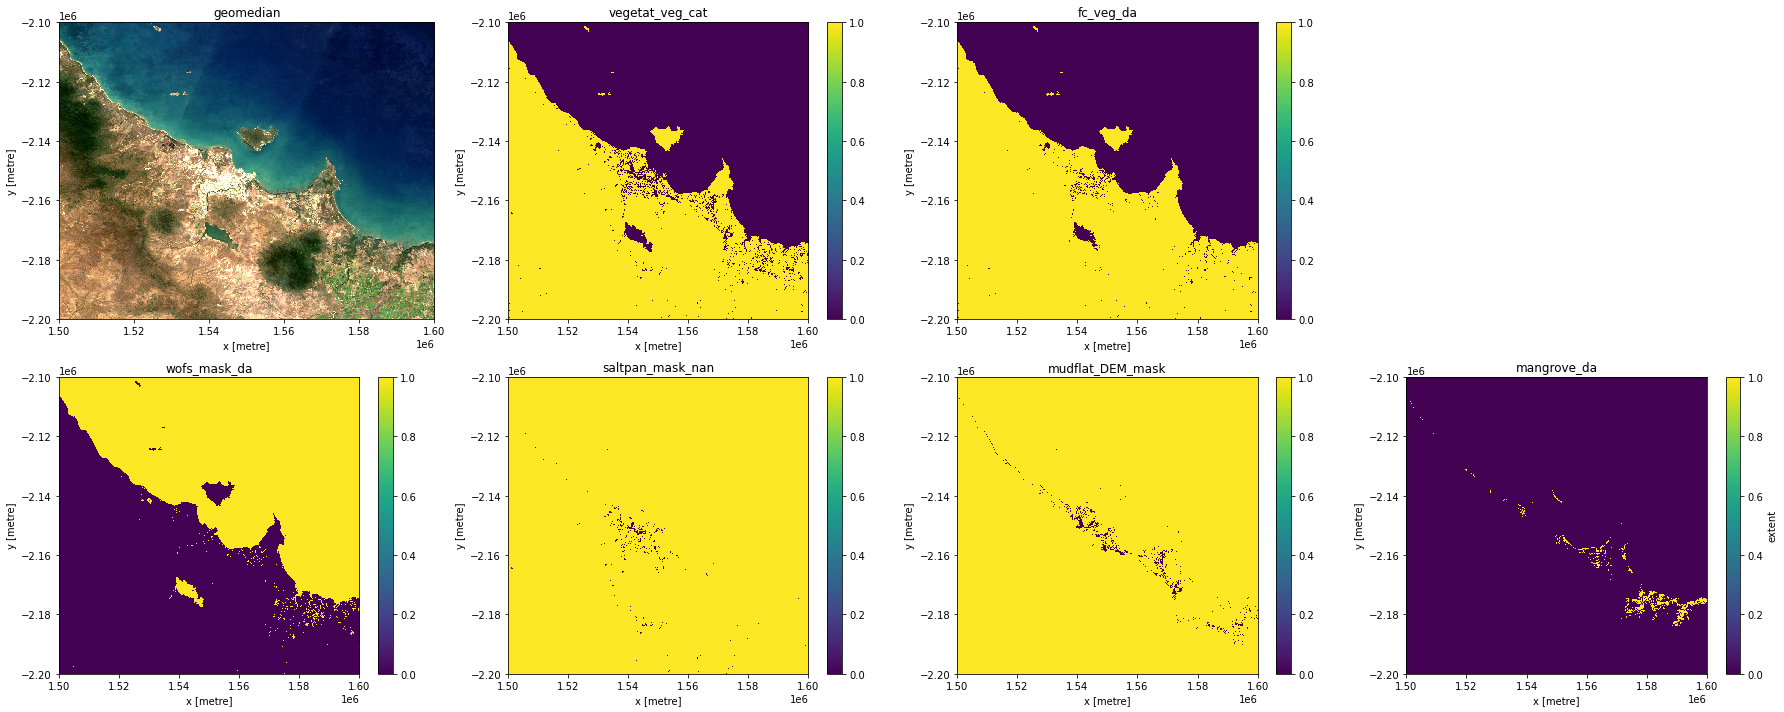

In [15]:
wofs_mask_inverted = (1-(wofs_mask_da))
mudflat_DEM_mask = (1-(mudflat_mask_nan_da * DEM_mask_da))

plt.figure(figsize=(25,10))
gs = gridspec.GridSpec(2,4)

ax1=plt.subplot(gs[0,0])
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)
ax1.set_title('geomedian')

ax2=plt.subplot(gs[0,1])
vegetat_veg_cat.plot.imshow()
ax2.set_title('vegetat_veg_cat')

ax3=plt.subplot(gs[0,2])
fc_veg_da.plot.imshow()
ax3.set_title('fc_veg_da')

ax4=plt.subplot(gs[1,0])
wofs_mask_da.plot.imshow()
ax4.set_title('wofs_mask_da')

ax5=plt.subplot(gs[1,1])
saltpan_mask_nan_da.plot.imshow()
ax5.set_title('saltpan_mask_nan')

ax6=plt.subplot(gs[1,2])
mudflat_DEM_mask.plot.imshow()
ax6.set_title('mudflat_DEM_mask')

ax7=plt.subplot(gs[1,3])
mangrove_da.plot.imshow()
ax7.set_title('mangrove_da')

plt.tight_layout()
plt.show()

In [16]:
# vegetat_veg_cat
# Get location of transformation
transformation = "le_plugins.le_level1"
trans_loc = importlib.import_module(transformation)
trans_class = transformation.split('.')[-1]
DEFAULT_RESOLVER.register('transform', trans_class, getattr(trans_loc, trans_class))

product = catalog['vegetat_veg_cat']
vegetat_veg_cat_plugin = product.load(dc, **query)
vegetat_veg_cat_plugin

/env/lib/python3.6/site-packages/datacube/virtual/utils.py:13: UserWarning: select_unique may have failed: {'crs': 'EPSG:3577', 'grid_mapping': 'spatial_ref'} is not the same as {}
  .format(first, other))


<xarray.Dataset>
Dimensions:          (x: 1000, y: 1000)
Coordinates:
    spatial_ref      int32 3577
  * x                (x) float64 1.5e+06 1.5e+06 1.5e+06 ... 1.6e+06 1.6e+06
  * y                (y) float64 -2.1e+06 -2.1e+06 ... -2.2e+06 -2.2e+06
Data variables:
    vegetat_veg_cat  (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    crs:      EPSG:3577

In [20]:
# #see what's already in the resolver 
# DEFAULT_RESOLVER.lookup_table['transform']